<a href="https://colab.research.google.com/github/MBilalSharif/Spam-Email-Detection/blob/main/Email_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Email Spam Detection System


##  Install & Import Libraries

In [16]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import re
import string
import warnings
import pickle
warnings.filterwarnings('ignore')

# NLTK for text processing
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

print(" All libraries imported successfully!")

 All libraries imported successfully!


##  Load Dataset

In [17]:
# Load the dataset
df = pd.read_csv('spam_ham_dataset.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nFirst 5 rows:")
display(df.head())
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nMissing values:\n{df.isnull().sum()}")

Dataset Shape: (5171, 4)

First 5 rows:


,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0



Column names: ['Unnamed: 0', 'label', 'text', 'label_num']

Missing values:
Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64


## 🔍 Data Exploration

 Label column: label_num
 Text column: text

Class Distribution:
label_num
0    3672
1    1499
Name: count, dtype: int64

Percentage:
label_num
0    71.01141
1    28.98859
Name: proportion, dtype: float64


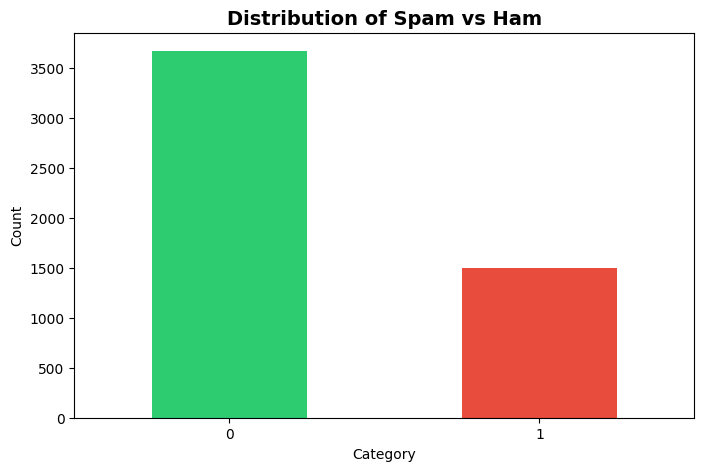

In [18]:
text_col = None
label_col = None

for col in df.columns:
    col_lower = col.lower()
    if 'text' in col_lower or 'message' in col_lower or 'email' in col_lower or 'sms' in col_lower:
        text_col = col
    if 'label' in col_lower or 'class' in col_lower or 'category' in col_lower or 'type' in col_lower:
        label_col = col

if text_col is None:
    text_col = df.columns[1] if len(df.columns) > 1 else df.columns[0]
if label_col is None:
    label_col = df.columns[0]

print(f" Label column: {label_col}")
print(f" Text column: {text_col}")

# Class distribution
print(f"\nClass Distribution:")
print(df[label_col].value_counts())
print(f"\nPercentage:")
print(df[label_col].value_counts(normalize=True) * 100)

# Visualize
plt.figure(figsize=(8, 5))
df[label_col].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c'])
plt.title('Distribution of Spam vs Ham', fontsize=14, fontweight='bold')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## Text Preprocessing

## Prepare Data for Modeling

In [19]:


# Split data
X = df['text']
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## 🔤 Feature Extraction (TF-IDF)

In [20]:
tfidf = TfidfVectorizer(min_df=1 , stop_words='english' ,lowercase=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"vectorization complete!")
print(f"Feature matrix shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf.vocabulary_)}")

vectorization complete!
Feature matrix shape: (4136, 43482)
Vocabulary size: 43482


##  Train Multiple Models

In [21]:
# Define models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n{'='*60}")
    print(f" Training {name}...")
    print('='*60)

    # Train
    model.fit(X_train_tfidf, y_train)

    # Predict
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1] if hasattr(model, 'predict_proba') else None

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc_score,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f" Accuracy: {accuracy:.4f}")
    if auc_score:
        print(f" AUC-ROC: {auc_score:.4f}")

    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))


 Training Naive Bayes...
 Accuracy: 0.9256
 AUC-ROC: 0.9981

Classification Report:
              precision    recall  f1-score   support

         Ham       0.91      1.00      0.95       735
        Spam       1.00      0.74      0.85       300

    accuracy                           0.93      1035
   macro avg       0.95      0.87      0.90      1035
weighted avg       0.93      0.93      0.92      1035


 Training Logistic Regression...
 Accuracy: 0.9913
 AUC-ROC: 0.9997

Classification Report:
              precision    recall  f1-score   support

         Ham       1.00      0.99      0.99       735
        Spam       0.97      1.00      0.99       300

    accuracy                           0.99      1035
   macro avg       0.99      0.99      0.99      1035
weighted avg       0.99      0.99      0.99      1035


 Training Random Forest...
 Accuracy: 0.9884
 AUC-ROC: 0.9989

Classification Report:
              precision    recall  f1-score   support

         Ham       1.00   

Test with Custom Examples

In [29]:
# Choose best model (example: highest AUC)
best_model_name = max(results, key=lambda x: results[x]['auc'] if results[x]['auc'] else 0)
model = results[best_model_name]['model']

print(f"Best model selected: {best_model_name}")

def predict_email(text):
    # Vectorize
    vectorized = tfidf.transform([text])

    # Predict
    prediction = model.predict(vectorized)[0]
    probability = model.predict_proba(vectorized)[0] if hasattr(model, 'predict_proba') else None

    label = 'SPAM' if prediction == 1 else 'HAM'
    return label, probability




Best model selected: Logistic Regression
Testing Examples:

Example 1:
  Text: Congratulations! You've won $1000. Click here to claim your prize now!...
  Prediction: SPAM
  Confidence: Ham=19.48%, Spam=80.52%

Example 2:
  Text: Hi John, can we meet tomorrow at 3pm to discuss the project?...
  Prediction: HAM
  Confidence: Ham=52.02%, Spam=47.98%

Example 3:
  Text: URGENT: Your account will be suspended unless you verify immediately...
  Prediction: SPAM
  Confidence: Ham=40.13%, Spam=59.87%

Example 4:
  Text: Hey, just checking if you're coming to dinner tonight?...
  Prediction: HAM
  Confidence: Ham=56.10%, Spam=43.90%



Test Example

In [30]:
test_examples = [
    "Congratulations! You've won $1000. Click here to claim your prize now!",
    "Hi John, can we meet tomorrow at 3pm to discuss the project?",
    "URGENT: Your account will be suspended unless you verify immediately",
    "Hey, just checking if you're coming to dinner tonight?"
]

print("Testing Examples:\n")

for i, example in enumerate(test_examples, 1):
    label, prob = predict_email(example)
    print(f"Example {i}:")
    print(f"  Text: {example[:70]}...")
    print(f"  Prediction: {label}")
    if prob is not None:
        print(f"  Confidence: Ham={prob[0]:.2%}, Spam={prob[1]:.2%}")
    print()

Testing Examples:

Example 1:
  Text: Congratulations! You've won $1000. Click here to claim your prize now!...
  Prediction: SPAM
  Confidence: Ham=19.48%, Spam=80.52%

Example 2:
  Text: Hi John, can we meet tomorrow at 3pm to discuss the project?...
  Prediction: HAM
  Confidence: Ham=52.02%, Spam=47.98%

Example 3:
  Text: URGENT: Your account will be suspended unless you verify immediately...
  Prediction: SPAM
  Confidence: Ham=40.13%, Spam=59.87%

Example 4:
  Text: Hey, just checking if you're coming to dinner tonight?...
  Prediction: HAM
  Confidence: Ham=56.10%, Spam=43.90%



## 💾 Save Model

In [27]:
with open('spam_detector_model.pkl', 'wb') as f:
    pickle.dump(results[best_model_name]['model'], f)

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print("💾 Model saved successfully!")


💾 Model saved successfully!
